In [7]:
import torch

# Functions to load and pre-process the images:
from skimage.io import imread
from skimage import img_as_ubyte
from sigver.preprocessing.normalize import (
    normalize_image, resize_image,
    crop_center, preprocess_signature)

# Functions to load the CNN model
from sigver.featurelearning.models import SigNet

# Functions for plotting:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'Greys'

In [8]:
def load_signature(path):
    return img_as_ubyte(imread(path, as_gray= True))
original= load_signature('C:/Users/SHUBHANKAR/data/some_signature.png')


In [9]:
normalized= 255-normalize_image(original,(952,1360))
resized = resize_image(normalized,(170,242))
cropped = crop_center(resized,(150,220))


Text(0.5, 1.0, 'Cropped center of the image')

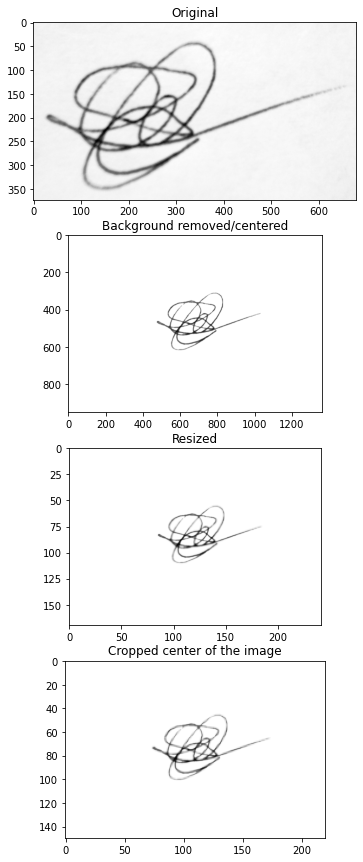

In [10]:
f, ax = plt.subplots(4,1, figsize=(6,15))
ax[0].imshow(original, cmap='Greys_r')
ax[1].imshow(normalized)
ax[2].imshow(resized)
ax[3].imshow(cropped)

ax[0].set_title('Original')
ax[1].set_title('Background removed/centered')
ax[2].set_title('Resized')
ax[3].set_title('Cropped center of the image')


In [11]:
user1_sigs  = [load_signature('C:/Users/SHUBHANKAR/data/a{}.png'.format(i)) for i in  [1,2]]
user2_sigs  = [load_signature('C:/Users/SHUBHANKAR/data/b{}.png'.format(i)) for i in  [1,2]]

canvas_size = (952, 1360)

processed_user1_sigs = torch.tensor([preprocess_signature(sig, canvas_size) for sig in user1_sigs])
processed_user2_sigs = torch.tensor([preprocess_signature(sig, canvas_size) for sig in user2_sigs])

In [12]:
# Inputs need to have 4 dimensions (batch x channels x height x width), and also be between [0, 1]

processed_user1_sigs = processed_user1_sigs.view(-1, 1, 150, 220).float().div(255)
processed_user2_sigs = processed_user2_sigs.view(-1, 1, 150, 220).float().div(255)

In [13]:
# If GPU is available, use it:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: {}'.format(device))

Using device: cpu


In [15]:
# Load the model
state_dict, _, _ = torch.load('C:/Users/SHUBHANKAR/anaconda3/Lib/site-packages/caffe2/python/models/signet.pth')
base_model = SigNet().to(device).eval()
base_model.load_state_dict(state_dict)

<All keys matched successfully>

In [16]:
# Obtain the features. Note that you can process multiple images at the same time

with torch.no_grad():
    user1_features = base_model(processed_user1_sigs.to(device))
    user2_features = base_model(processed_user2_sigs.to(device))

In [17]:
user1_features.shape

torch.Size([2, 2048])

In [18]:
print('Euclidean distance between signatures from the same user')
print(torch.norm(user1_features[0] - user1_features[1]))
print(torch.norm(user2_features[0] - user2_features[1]))

Euclidean distance between signatures from the same user
tensor(15.3833)
tensor(15.1755)


In [19]:
print('Euclidean distance between signatures from different users')

dists = [torch.norm(u1 - u2).item() for u1 in user1_features for u2 in user2_features]
print(dists)

Euclidean distance between signatures from different users
[24.93024253845215, 26.87916374206543, 24.48971939086914, 26.906970977783203]
